In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [45]:
from filterpy.kalman import KalmanFilter, IMMEstimator
from filterpy.common import kinematic_kf
from tracking import ConstantUpdatePolicy, ResidualUpdatePolicy, RandomUpdatePolicy
from radar import Radar2D
from target import SingerModelMD, TargetOnTrajectory
from simulation import simulation_loop
from plotting import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


plt.style.use('ggplot')

# Simulate two dimensional Singer model

In [3]:
# Common parameters
dt = 0.01
horizon = 10000
t = dt*np.arange(horizon)

In [13]:
# Create simulation objects

target = SingerModelMD(
    stdAcc=0.4, 
    corrAcc=0.5, 
    x0=np.array([[5e3, -1e2, 0, 5e3, 1e2, 0]]), 
    dim=2, 
    dt=dt,
)

tracker = kinematic_kf(
    dim=2, 
    order=2,
    dt=0.1
)

radar = Radar2D(
    sn0=50,
    beamwidth=np.pi/64,
    prob_f=1e-8,
    order=2,
)

update_policy = ResidualUpdatePolicy(v0=1, K_min=1, K_max=10)

In [28]:
# Initialize parameters
def initialize():
    target.reset()
    tracker.x = target.x
    tracker.P = 100*np.eye(6)
    tracker.Q = np.eye(6) * 1e-9
    update_policy.reset()

In [29]:
initialize()
data = simulation_loop(target, radar, tracker, update_policy, horizon)

<IPython.core.display.Javascript object>


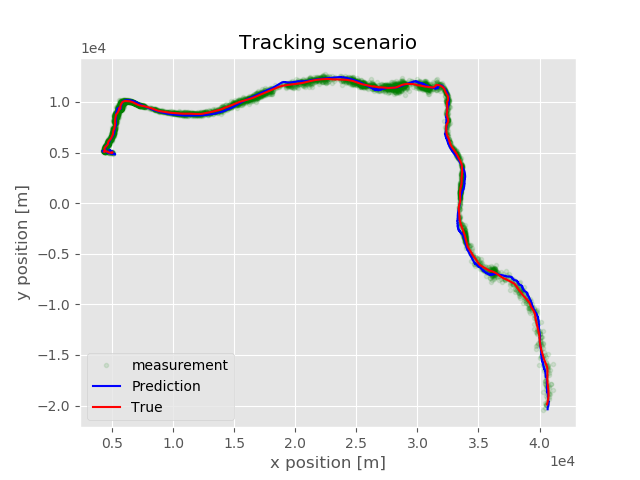

In [30]:
plot_scenario(data, 2)
plt.savefig('figs/scenario.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


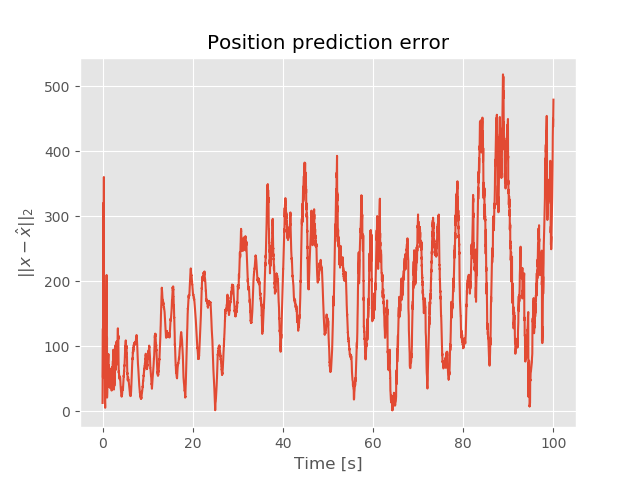

In [31]:
plot_prediction_error(data, t, 2)
plt.savefig('figs/position_error.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


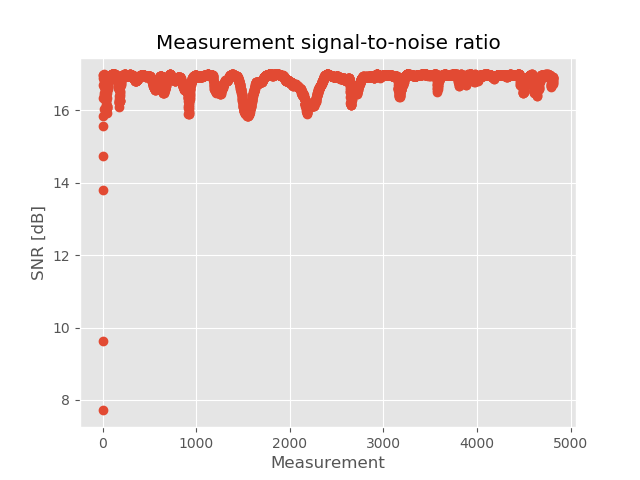

In [32]:
plot_snr(data)
plt.savefig('figs/snr.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


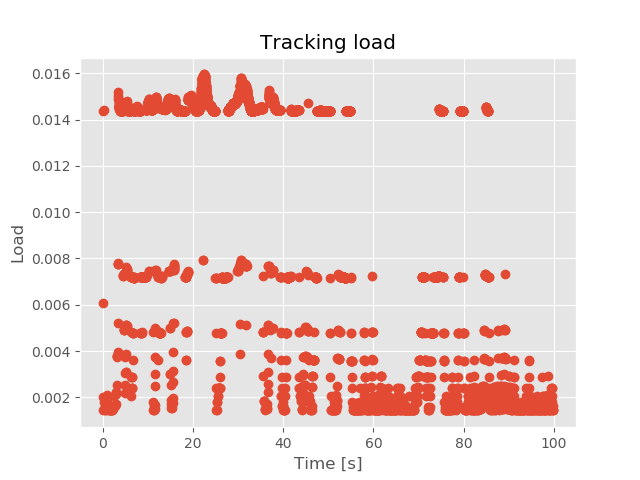

In [33]:
plot_tracking_load(data, t, dt)
plt.savefig('figs/load.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


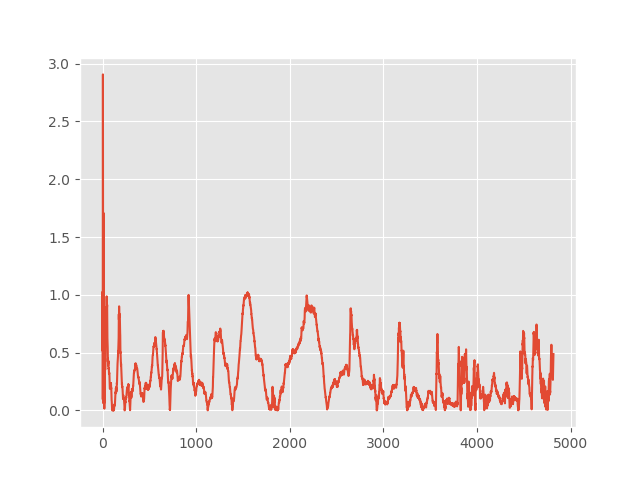

In [34]:
plot_angular_error(data)

<IPython.core.display.Javascript object>


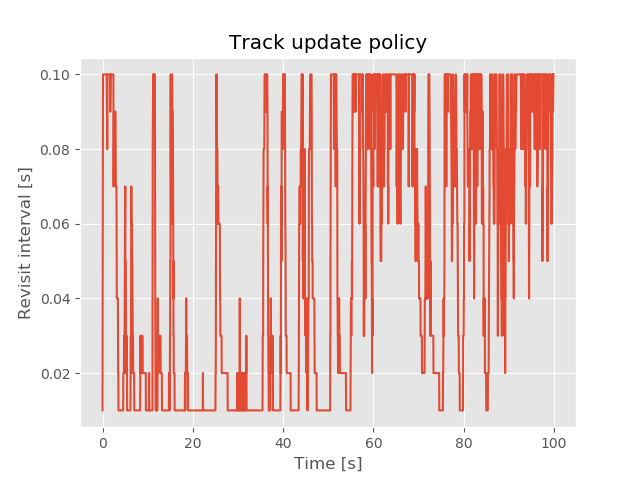

In [35]:
plot_update_policy(data, t, dt)
plt.savefig('figs/update_policy.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


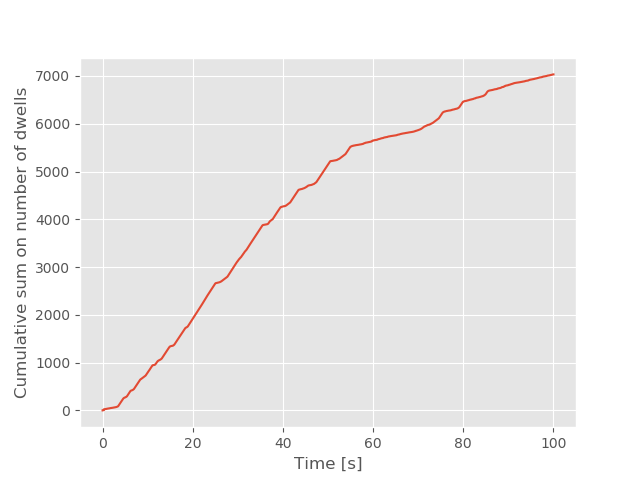

In [37]:
plot_n_dwells(data, dt)

# Benchmark dataset

## Task 1. Load the dataset and create pandas data frame

In [38]:
trajectories = list()
for i in range(1, 6+1):
    trajectories.append(pd.read_csv('trajectories/traj_{}.csv'.format(i), header=None).to_numpy())

## Task 2. Visualize the dataset

### 3D trajectory

<IPython.core.display.Javascript object>


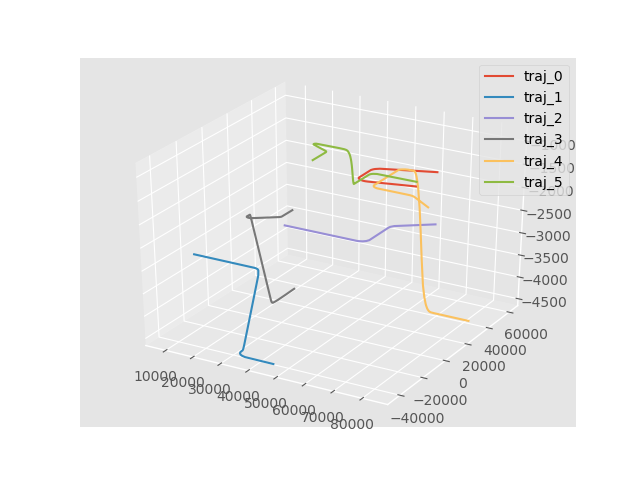

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    trajectory = trajectories[i]
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='traj_' + str(i))
plt.show()
plt.legend()  

### 2D trajectory

<IPython.core.display.Javascript object>


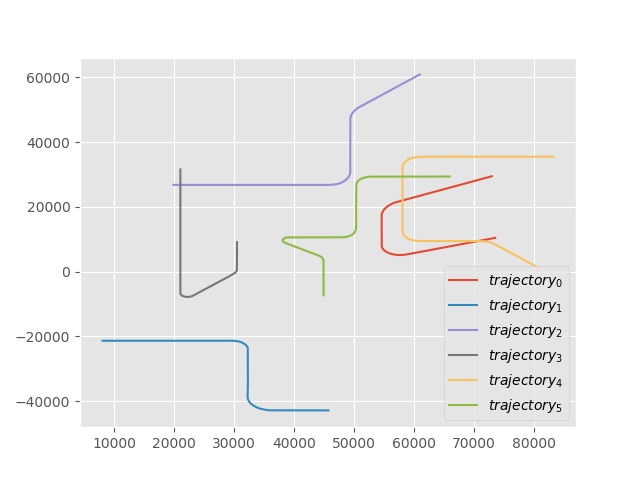

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(6):
    trajectory = trajectories[i]
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], label='$trajectory_' + str(i) + '$')
plt.show()
plt.legend()

## Task 3. Create function to preprocess the data to be applicable for general tracking problem

The target state must be in form of (x, x', x'', y, y', y'') etc. with spesific model order and dimensions. Note that this is applicable only for simulations where position is tracked. 

In [42]:
def preprocess_trajectory_data(trajectory, dim, order):
    traj_trunc = trajectory[:, :dim]  # get the data up to desired dimension
    states = np.zeros((traj_trunc.shape[0], traj_trunc.shape[1] * (order+1)))  # Add additional dimensions based on the order
    states[:, ::(order+1)] = traj_trunc
    return states

In [16]:
preprocess_trajectory_data(trajectories[0], 2, 2)[:5, :]

array([[72944.,     0.,     0., 29473.,     0.,     0.],
       [72942.,     0.,     0., 29471.,     0.,     0.],
       [72939.,     0.,     0., 29470.,     0.,     0.],
       [72937.,     0.,     0., 29469.,     0.,     0.],
       [72934.,     0.,     0., 29468.,     0.,     0.]])

## Task 3. Simulate Kalman filter on a baseline trajectory

### Create simulation objects

In [140]:
trajectory = preprocess_trajectory_data(trajectories[1], dim=2, order=1)
t = np.arange(len(trajectory)-1)*dt

target = TargetOnTrajectory(trajectory)

tracker = kinematic_kf(
    dim=2, 
    order=1,
    dt=dt
)

radar = Radar2D(
    sn0=50,
    beamwidth=np.pi/64,
    prob_f=1e-4,
    order=1,
)

update_policy = ResidualUpdatePolicy(v0=1, K_max=1000, K_min=1)
# update_policy = ConstantUpdatePolicy(1)

### Simulate

In [141]:
target.reset()
update_policy.reset()
tracker.x = target.x
tracker.P = np.eye(target.x.size) * 1000
tracker.Q = np.eye(target.x.size) * 1e-7
# tracker.F = constant_turn_rate_matrix(-0.3, dt)
data = simulation_loop(target, radar, tracker, update_policy, len(trajectory)-1)

<IPython.core.display.Javascript object>


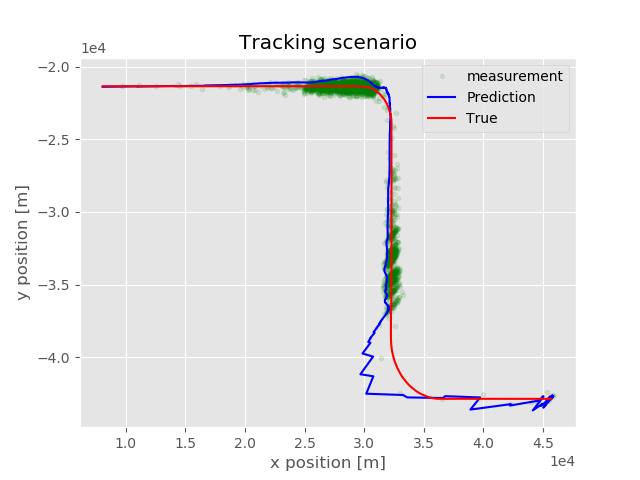

In [142]:
plot_scenario(data, order=1)

<IPython.core.display.Javascript object>


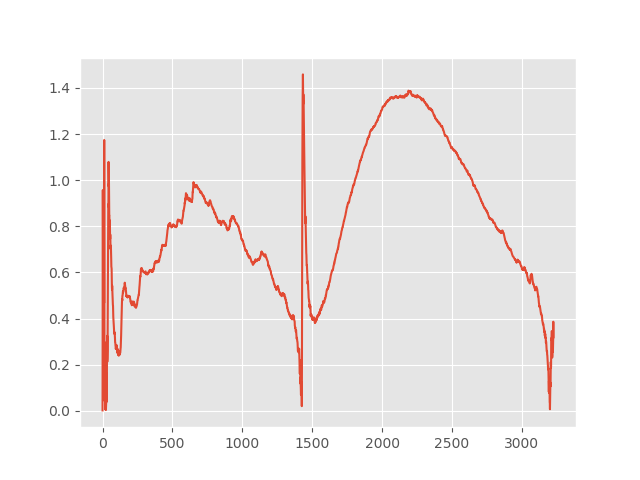

In [122]:
plot_angular_error(data)

<IPython.core.display.Javascript object>


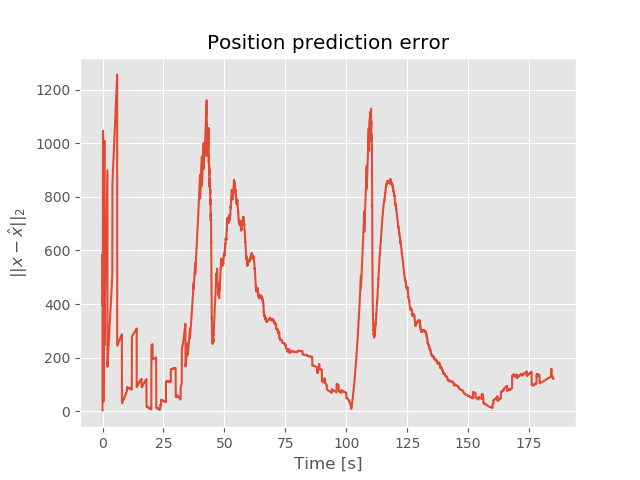

In [123]:
plot_prediction_error(data, t, 1)

<IPython.core.display.Javascript object>


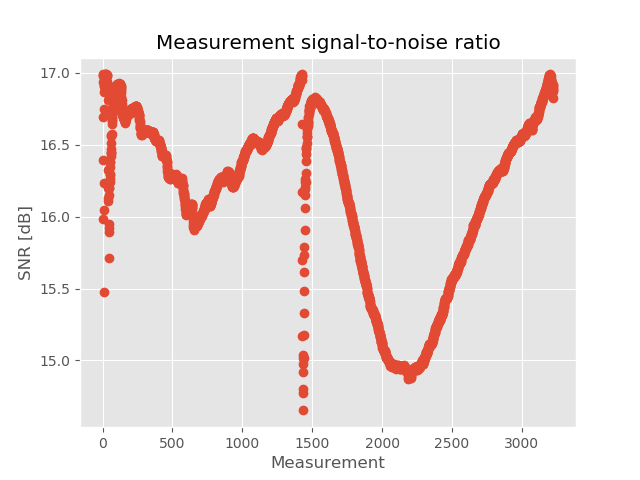

In [124]:
plot_snr(data)

<IPython.core.display.Javascript object>


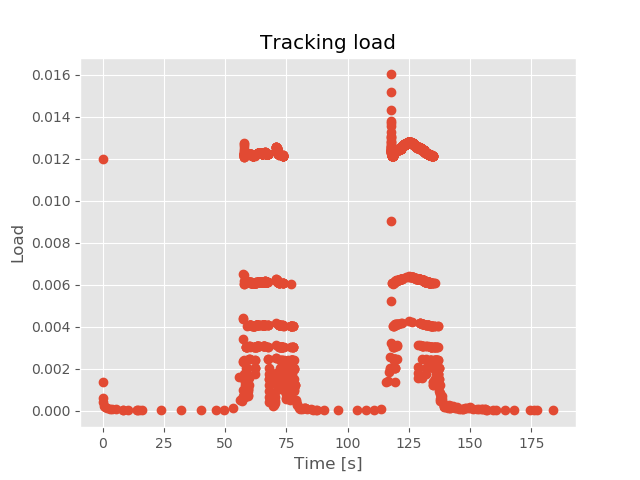

In [138]:
plot_tracking_load(data, t, dt)

<IPython.core.display.Javascript object>


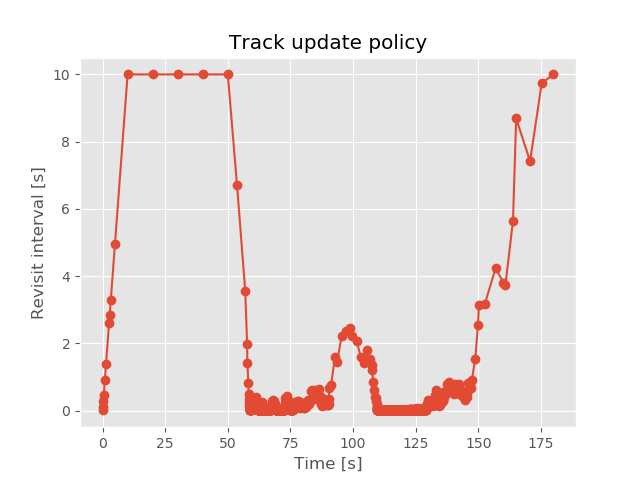

In [143]:
plot_update_policy(data, t, dt)

<IPython.core.display.Javascript object>


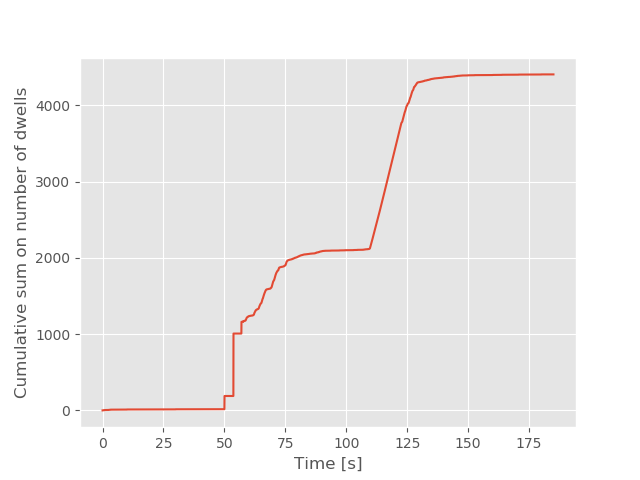

In [146]:
plot_n_dwells(data, dt)

<IPython.core.display.Javascript object>


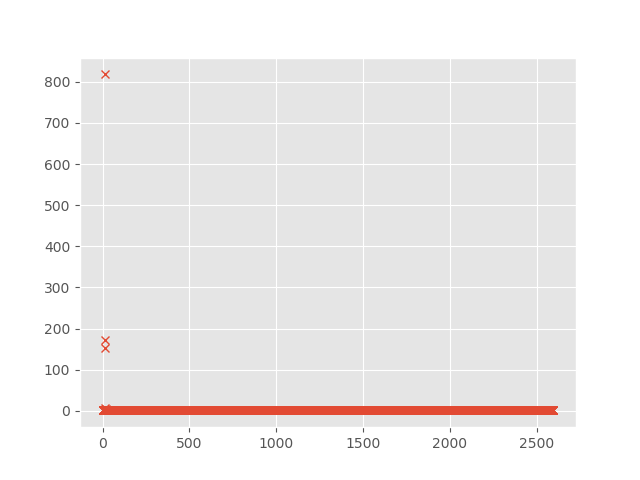

In [148]:
plt.figure()
plt.plot([meas.n_dwells for meas in data.measurements], 'x')

## Task 4. Simulate IMM estimator on a baseline trajectory

In [176]:
update_policy = ResidualUpdatePolicy(v0=1, K_max=200)
# update_policy = ConstantUpdatePolicy(100)

kf1 = kinematic_kf(
    dim=2, 
    order=1,
    dt=dt
)
kf1.Q = np.eye(target.x.size) * 0

kf2 = kinematic_kf(
    dim=2, 
    order=1,
    dt=dt
)
kf2.Q = np.eye(target.x.size) * 1e-8

kf3 = kinematic_kf(
    dim=2,
    order=1,
    dt=dt
)
kf3.Q = np.eye(target.x.size) * 0
kf3.F = constant_turn_rate_matrix(0.4, dt)
kf4 = kinematic_kf(
    dim=2,
    order=1,
    dt=dt
)
kf4.Q = np.eye(target.x.size) * 0
kf4.F = constant_turn_rate_matrix(-0.4, dt)
'''
filters = [kf1, kf2, kf3, kf4]
mu = [0.25, 0.25, 0.25, 0.25]
trans = np.array([
    [0.90, 0.02, 0.04, 0.04], 
    [0.04, 0.90, 0.02, 0.02],
    [0.05, 0.02, 0.90, 0.01],
    [0.05, 0.02, 0.01, 0.90]
])
'''

filters = [kf1, kf2]
mu =[0.5, 0.5]
trans = np.array([
    [0.97, 0.03],
    [0.03, 0.97]
])
tracker = IMMEstimator(filters, mu, trans)

In [177]:
target.reset()
update_policy.reset()
for idx in range(len(tracker.filters)):
    tracker.filters[idx].P = np.eye(target.x.size) * 1000
    tracker.filters[idx].x = target.x
tracker.Q = np.eye(target.x.size) * 1e-6
data = simulation_loop(target, radar, tracker, update_policy, len(trajectory)-1)

<IPython.core.display.Javascript object>


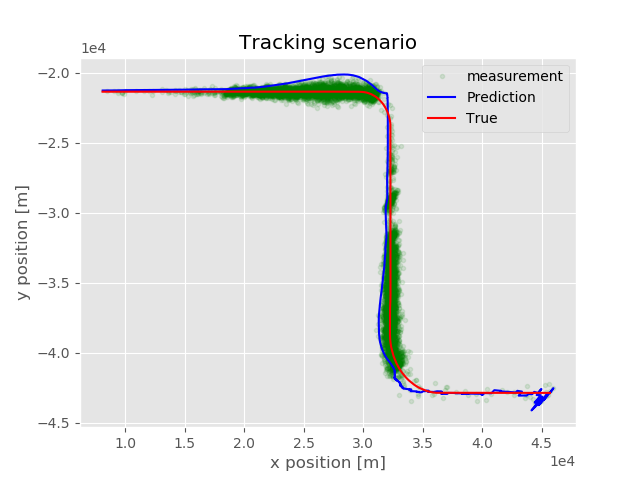

In [178]:
plot_scenario(data, order=1)

<IPython.core.display.Javascript object>


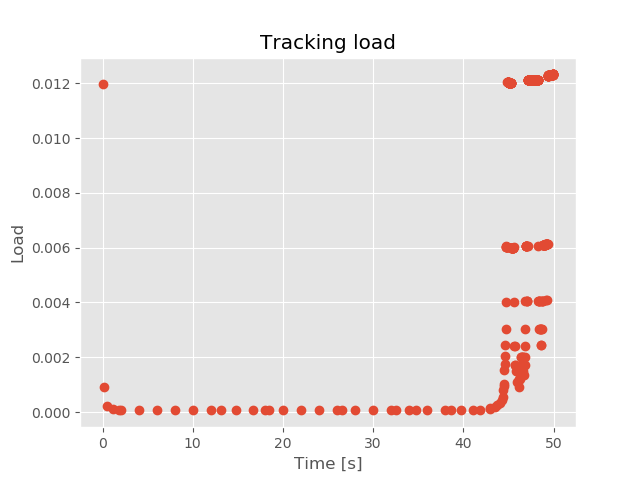

In [170]:
plot_tracking_load(data, t, dt)

<IPython.core.display.Javascript object>


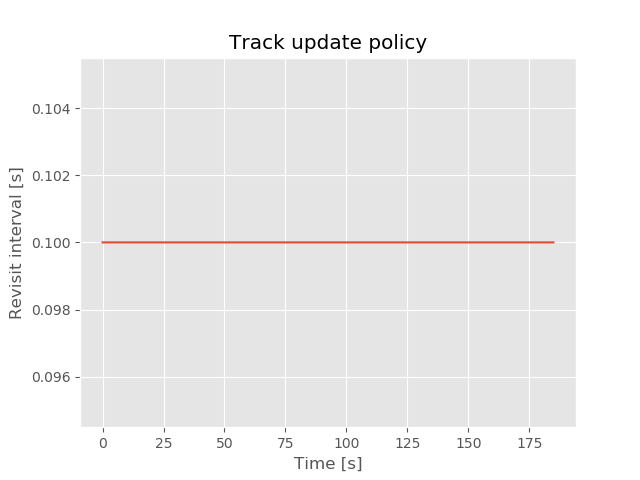

In [92]:
plot_update_policy(data, t, dt)

<IPython.core.display.Javascript object>


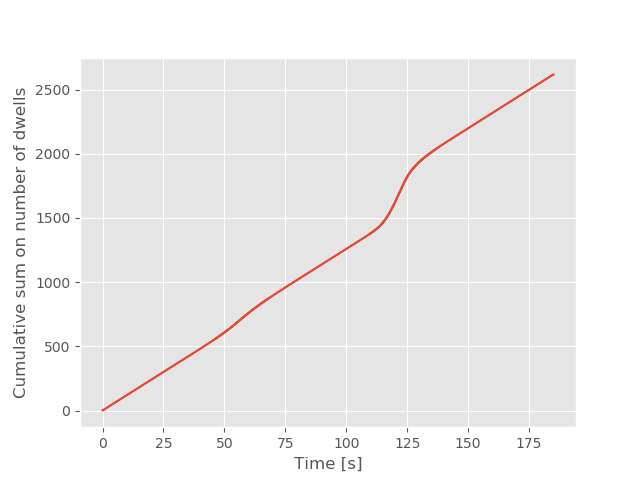

In [91]:
plot_n_dwells(data, dt)

<IPython.core.display.Javascript object>


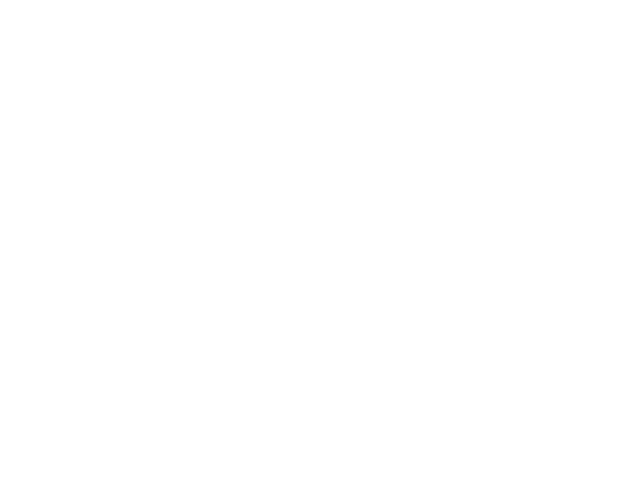

ValueError: x and y must have same first dimension, but have shapes (18499,) and (5000,)

In [173]:
plot_prediction_error(data, t, 1)

In [3]:
from target import constant_turn_rate_matrix

In [6]:
constant_turn_rate_matrix(0.2, dt)

array([[ 1.00000000e+00,  9.99999333e-03,  0.00000000e+00,
        -9.99999667e-06],
       [ 0.00000000e+00,  9.99998000e-01,  0.00000000e+00,
        -1.99999867e-03],
       [ 0.00000000e+00,  9.99999667e-06,  1.00000000e+00,
         9.99999333e-03],
       [ 0.00000000e+00,  1.99999867e-03,  0.00000000e+00,
         9.99998000e-01]])

<IPython.core.display.Javascript object>


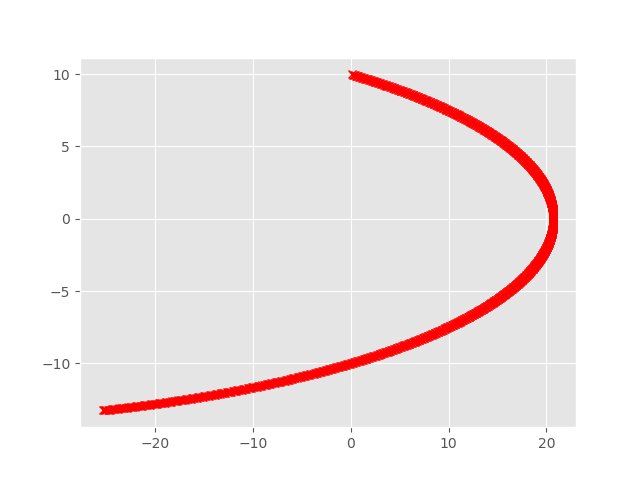

In [27]:
x = np.array([0, 10, 0, 10])
for i in range(1000):
    x = constant_turn_rate_matrix(0.2, dt)@x
    pos = x
    plt.plot(pos[0], pos[1], 'xr')

In [138]:
random_seq = np.abs(2 * np.random.randn(1000) - 5*np.random.randn(1000))


<IPython.core.display.Javascript object>


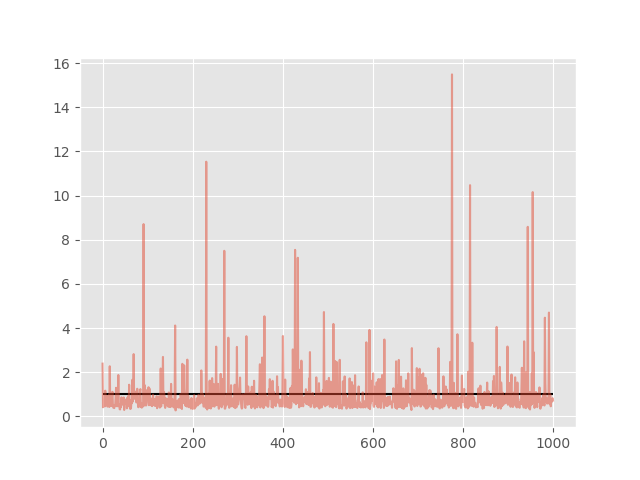

In [161]:
cs = np.sqrt(1.5/random_seq)
plt.figure()
plt.plot(cs, alpha=0.5)
plt.hlines(1, 0, 1000)
plt.show()

In [162]:
np.sum(cs[cs > 1])

467.20674654023117

In [163]:
np.sum(cs[cs < 1])

464.04970534895665

In [171]:
np.sqrt(3/np.abs(np.random.randn(1000)*3).mean())

1.1282909506402863